In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
from scipy.signal import find_peaks
import math
import os

In [20]:
# Cough audio loading
audio_num = 2
cough_audio = "./records/audio-" + str(audio_num) + ".wav"
cough_timestamps = "./timestamps/audio-" + str(audio_num) + "-label.txt"

# Target sample rate: 48000
data, sample_rate = librosa.load(cough_audio, sr=48000)


# Audio duration
duration = librosa.get_duration(path = cough_audio)
total_samples = duration * sample_rate
time = np.arange(0, len(data)) / sample_rate

print("Audio Duration: {}".format(duration))
print("Sample Rate: {}".format(sample_rate))

Audio Duration: 60.09229166666667
Sample Rate: 48000


In [21]:
# Read timestamps text file

f = open(cough_timestamps, "r")
content = f.read()
content = content.split("\n")

real_timestamps = []
for line in content:
    if line != "":
        real_timestamps.append(float(line.split("\t")[0]))

print("Real Timestamps: ", real_timestamps)


Real Timestamps:  [4.007188, 6.963311, 12.021565, 23.231565, 27.590476, 39.531973, 45.244082, 56.29678]


In [6]:
# The audio
Audio(cough_audio)

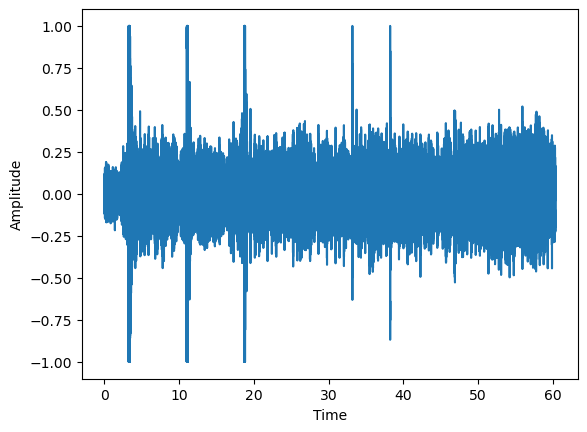

In [7]:
# Data graph
plt.plot(time, data)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

In [8]:
# Filtering the Data:



In [9]:
# Moving Average of the Data:
def moving_average(data, window_size):
    
    moving_averages = []

    i = 0
    while i < len(data) - window_size + 1:
        
        window = data[i : i + window_size]
        window_average = round(np.sum(window) / window_size, 2)
        moving_averages.append(window_average)

        i += 1    
    
    return np.array(moving_averages)

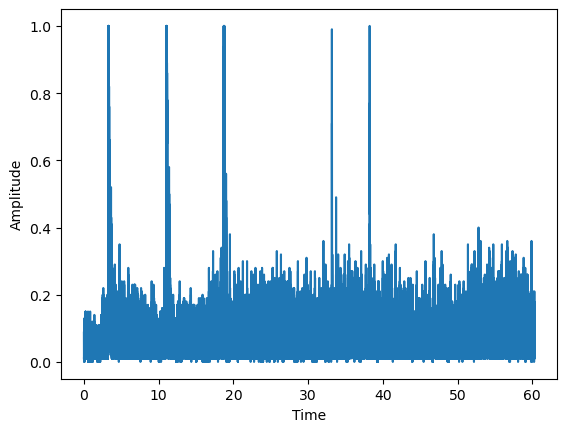

In [10]:
# Graph of moving average of the data and normal data

filter_length = 15
moving_avg_data = moving_average(np.abs(data), filter_length)

# Data normalization

"""
mean = np.mean(moving_avg_data)
std = np.std(moving_avg_data)

moving_avg_data = (moving_avg_data - mean) / std
"""

min = np.min(moving_avg_data)
max = np.max(moving_avg_data)

moving_avg_data = (moving_avg_data - min) / (max - min)

# Time 
time_data = np.arange(0, len(data)) / sample_rate
time_moving_avg = np.arange(0, len(moving_avg_data)) * (len(data) / len(moving_avg_data)) / sample_rate

# Plotting the graph

#plt.plot(time_data, data)
plt.plot(time_moving_avg, moving_avg_data)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

1.0
0.07303409959053701
0.06438598035940671


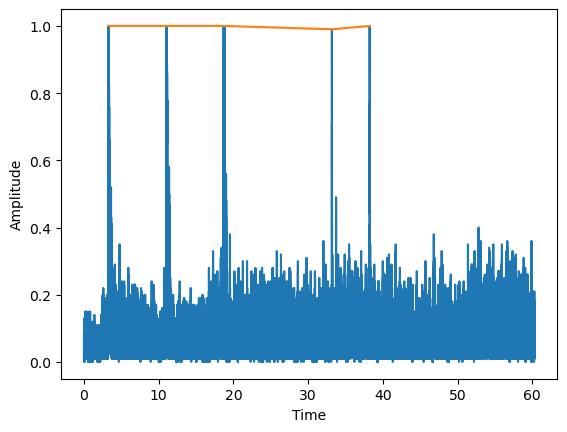


Cough Count: 5
Cough Timestamps: [3.245229, 11.022312, 18.711312, 33.183729, 38.235833]
Cough Indices: [155771, 529071, 898143, 1592819, 1835320]


In [11]:
# Finding the number of coughs with a threshold

# Statistics of the data
max_value = np.max(moving_avg_data)
mean_value = np.mean(moving_avg_data)
std = np.std(moving_avg_data)

print(max_value)
print(mean_value)
print(std)

# Threshold 
percentile_threshold = 99.8
threshold = np.percentile(moving_avg_data, percentile_threshold)

# Peak detection
cough_indices, _ = find_peaks(moving_avg_data, prominence = 0.5)
cough_indices = list(cough_indices)

# Deleting overlaps in the peaks - Avoiding to count same cough more than one
i = 0
while i < len(cough_indices):
    
    peak = cough_indices[i]
    peak_range = (peak - 5000, peak + 5000) # The range is determined experimentally
    
    overlap_indices = [index for index in cough_indices
                   if peak_range[0] < index < peak_range[1]]
 
    if len(overlap_indices) > 1:
        
        # Find the index with maximum amplitude 
        max = overlap_indices[0]
        for index in overlap_indices:
            if (moving_avg_data[index] > moving_avg_data[max]):
                max = index
        
        overlap_indices.remove(max)
        
        for element in overlap_indices:
            cough_indices.remove(element)
        
    i += 1
    

# Applying the threshold
cough_indices_copy = cough_indices.copy()
for index in cough_indices_copy:
    
    amplitude = moving_avg_data[index]
    
    if (amplitude < threshold):
        cough_indices.remove(index)
    
    
# Finding the timestamps of the coughs
predicted_timestamps = []
for index in cough_indices:
    predicted_timestamps.append(round(index / sample_rate, 6))

    
# Filtering the sound after coughing
for ts in predicted_timestamps:
    matches = list((ts_2 for ts_2 in predicted_timestamps if ts < ts_2 < ts + 0.4))
    
    if len(matches) != 0:
        for i in range(len(matches)):
            index = predicted_timestamps.index(matches[i])
            predicted_timestamps.remove(matches[i])
            cough_indices.remove(cough_indices[index])

    
# Graph
upper_envelope = moving_avg_data[cough_indices]
time = np.arange(0, len(moving_avg_data)) / sample_rate
time_envelope = time[cough_indices]

plt.plot(time, moving_avg_data)
plt.plot(time_envelope, upper_envelope)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

cough_count = len(cough_indices)

# The results
print("\nCough Count: {}".format(cough_count))
print("Cough Timestamps: {}".format([round(timestamp, 6) for timestamp in predicted_timestamps]))
print("Cough Indices: {}".format(cough_indices))


In [12]:
# Comparing the real timestamps and predicted timestamps.

time_margin = 0.05 # In seconds

print(predicted_timestamps)
print(real_timestamps)

true_positive = 0 
false_positive = 0

if (len(predicted_timestamps) > len(real_timestamps)):

    for pred in predicted_timestamps:
        match = list((rt for rt in real_timestamps if pred - 0.4 < rt < pred + 0.4))

        if len(match) != 0:
            true_positive += 1
        else:
            false_positive += 1

else:

    for pred in real_timestamps:
        match = list((rt for rt in predicted_timestamps if pred - 0.4 < rt < pred + 0.4))

        if len(match) != 0:
            true_positive += 1
        else:
            false_positive += 1

precision = true_positive / (true_positive + false_positive)
# Recall is assumed as 1 since the model does not predict the absence of coughs
recall = 1

f1_score = 2 * (precision * recall) / (precision + recall)
print(f1_score)

[3.245229, 11.022312, 18.711312, 33.183729, 38.235833]
[3.297234, 11.052698, 18.761723]
0.7499999999999999
